<a href="https://colab.research.google.com/github/nv-hiep/Moving_Charge/blob/main/Moving_Charge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Electromagnetic Field of Accelerated Charged Particle: Describe the change of the electromagnetic eld of a charged particle caused by its motions (uniform, acceler-ated, oscillating, or near the speed of light).

# Libraries

In [ ]:
### CREATE VIRTUAL DISPLAY ###
!apt-get install -y xvfb # Install X Virtual Frame Buffer
import os
os.system('Xvfb :1 -screen 0 1600x1200x16  &')    # create virtual display with size 1600x1200 and 16 bit color. Color can be changed to 24 or 8
os.environ['DISPLAY']=':1.0'    # tell X clients to use our virtual DISPLAY :1.0.

In [ ]:
#!/usr/bin/env python
__author__ = 'Hiep Nguyen'
import os
import sys
try:               # Python 2.7x
    import Tkinter as tk
    import ttk
    import tkFont
    import tkMessageBox
    import tkFileDialog
    import tkSimpleDialog
    from ScrolledText import ScrolledText as tkScrolledText
except Exception:  # Python 3.x
    import tkinter as tk
    from tkinter import ttk
    import tkinter.font as tkFont
    import tkinter.messagebox as tkMessageBox
    import tkinter.filedialog as tkFileDialog
    import tkinter.simpledialog as tkSimpleDialog

In [ ]:
import numpy                as np
import matplotlib           as mpl
import matplotlib.pyplot    as plt
import matplotlib.animation as animation
mpl.use("Agg")
from matplotlib.figure                 import Figure
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from matplotlib.backends.backend_tkagg import NavigationToolbar2Tk

# Webcam library
try:
    import cv2
    hasCV2 = True
except ImportError:
    hasCV2 = False

# Disable cv2 use on Mac OS because of buggy implementation
if sys.platform=="darwin":
    hasCV2 = False

In [ ]:
%matplotlib inline

In [ ]:
### INSTALL GHOSTSCRIPT (Required to display NLTK trees) ###
!apt install ghostscript python3-tk

# GUI with tk.Frame

In [ ]:
# Here, we are creating our class, Window, and inheriting from the Frame
# class. Frame is a class from the tkinter module. (see Lib/tkinter/__init__)
class Window(tk.Frame):

    # Define settings upon initialization. Here you can specify
    def __init__(self, master=None):
        
        # parameters that you want to send through the Frame class. 
        tk.Frame.__init__(self, master)   

        #reference to the master widget, which is the tk window                 
        self.master         = master
        
        self.bg_colour      = '#ececec'
        self.txtfont        = 'TkFixedFont'
        self.array          = ''
        self.C              = 2.99792458e8 # m/s - speed of light
        self.choices        = ['Accelerated Charge', 'Bremsstrahlung', 'Oscillating Charge']
                               # 'Free electron laser', 'Synchrotron1', 'Synchrotron2']



        # changing the title of our master widget      
        self.master.title('Moving charge')
        
        #with that, we want to then run init_window, which doesn't yet exist
        self.init_window()

    





    #Creation of init_window
    def init_window(self):

        # Add a grid
        self.mainframe = ttk.Frame(self.master)
        self.mainframe.grid(row=0, column=0, sticky='NWES' )
        self.mainframe.columnconfigure(0, weight = 1)
        self.mainframe.rowconfigure(0, weight = 1)
        self.mainframe.pack(side='left', fill='both', expand=True, pady = 10, padx = 10)

        # creating a menu instance
        menu = tk.Menu(self.master)
        self.master.config(menu=menu)


        # create the file object)
        file = tk.Menu(menu, tearoff=True)

        # adds a command to the menu option, calling it exit, and the
        # command it runs on event is client_exit
        file.add_command(label='Exit', command=self.client_exit)

        #added "file" to our menu
        menu.add_cascade(label='File', menu=file)

        



        # create the file object)
        edit = tk.Menu(menu, tearoff=True)

        # adds a command to the menu option, calling it exit, and the
        # command it runs on event is client_exit
        edit.add_command(label='Undo')

        #added "file" to our menu
        menu.add_cascade(label='Edit', menu=edit)




        # create the file object)
        help = tk.Menu(menu, tearoff=True)

        # adds a command to the menu option, calling it exit, and the
        # command it runs on event is client_exit
        help.add_command(label='Guide',
            command=lambda filename='docs/HELP.txt',
            title='Radio Array Instructions': self.show_textfile(filename, title) )

        #added "file" to our menu
        menu.add_cascade(label='Help', menu=help)




        # Set the grid expansion properties
        # self.mainframe.columnconfigure(0, weight=0)
        # self.mainframe.rowconfigure(0, weight=1)



        # For array configurations
        self.sel = tk.StringVar(self.master)

        
        self.sel.set(self.choices[0]) # set the default option

        arr_menu   = tk.OptionMenu(self.mainframe, self.sel, *self.choices, command=self.change_dropdown)
        # tk.Label(self.mainframe, text='Select').grid(row=0, column=0, padx=5, pady=2, sticky='W')
        arr_menu.grid(row=0, column=0, padx=5, pady=2, sticky='W')
        self.plot_ant_config()


        ## Exit
        tk.Button(self.mainframe, text='Exit', bg='red', fg='black',
            command=self.client_exit).grid(row=0, column=1, columnspan=2, padx=5, pady=2, sticky='E')







    def client_exit(self):
        exit()






    # on change dropdown value
    def change_dropdown(self,value):
        self.plot_ant_config()



    def plot_ant_config(self):

        self.phi    = np.arange(0., 360., 15.)*np.pi/180.

        t      = -10.
        p      = self.get_pos(t, self.sel.get())[0]

        tarray = np.arange(t-15., t, 0.1)

        self.nrow   = len(self.phi)
        self.ncol   = 2                    # x and y
        self.ndepth = len(tarray)


        dat = np.zeros( (self.nrow, self.ncol, self.ndepth) )
        for (i,xt) in enumerate(tarray):
            # a = get_pos(xt)         # [1x2] -> 1st column: x, 2nd column: y
            # b = cal_lambda(t,phi)   # [24x2] -> 1st column: x, 2nd column: y for 24 values of phi
            x = self.get_pos(xt, self.sel.get()) + (t-xt)*self.cal_lambda(xt)
            dat[:,:,i] = x


        self.fig = Figure(figsize=(6, 6))
        self.a   = self.fig.add_subplot(111)

        canvas = FigureCanvasTkAgg(self.fig, master=self.mainframe)
        # canvas.get_tk_widget().pack()
        canvas.get_tk_widget().grid(row=1, column=0, columnspan=2, padx=5, pady=2, sticky="EW")

        for i in range(self.nrow):
            # ax.plot(dat[:,0,:], dat[:,1,:])
            self.a.plot(dat[i,0,:], dat[i,1,:], 'k-')

        points = self.a.plot(p[0], p[1], 'ro', markersize=10)

        ani = animation.FuncAnimation(self.fig, self.update, frames=np.arange(-3., 11., 0.1), fargs=(points), interval=1, repeat=False)

        self.a.grid()
        self.a.set_title ('', fontsize=10)
        self.a.set_ylabel('North-South [km]', fontsize=8)
        self.a.set_xlabel('East-West [km]', fontsize=8)
        self.a.tick_params(axis='x', direction='in', labelsize=7, pad=5)
        self.a.tick_params(axis='y', direction='in', labelsize=7)
        self.a.set_xlim(-5., 5.)
        self.a.set_ylim(-5., 5.)
        self.a.legend(loc='upper left', fontsize=8, handletextpad=0.0, handlelength=0)
        
        canvas.draw()
        plt.close()







    def show_textfile(self, filename, title=''):
        """Show a text file in a new window."""

        win = tk.Toplevel(background=self.bg_colour)
        win.title(title)
        txt = tkScrolledText(win, width=80, font=self.txtfont)
        txt.config(state="normal")
        with open(filename,'r') as f:
            text = f.read()
        txt.insert('1.0', text)
        txt.config(state="disabled")
        txt.grid(column=0, row=0, padx=5, pady=2, sticky="NSEW")
        xbtn = ttk.Button(win, text='Close',
                                   command=win.destroy)
        xbtn.grid(column=0, row=1, padx=5, pady=2, sticky="E")
        win.rowconfigure(0, weight=1)
        win.columnconfigure(0, weight=1)



    def norm(self, v):
        # A     = np.linalg.norm( v, axis=1 )
        # vnorm = np.zeros_like(v)
        # for i in range(len(vnorm)):
        #   vnorm[i] = v[i]/A[i]

        if(np.sum(v**2) == 0.):
            return v*0.

        return v / np.sqrt(np.sum(v**2))


    def vec_dot(self, n,v):
        # nr,nc = v.shape
        # ret   = np.zeros(nr)
        # for i in range(nr):
        #   ret[i] = np.dot(n, v[i])

        return np.dot(n, v[i])


    def vec_dott(self, v,n):
        nr,nc = v.shape
        ret   = np.zeros(nr)
        for i in range(nr):
            ret[i] = np.dot(v[i], n)

        return ret      


    def cal_lambda(self, t):
        v     = self.get_vel(t, self.sel.get())
        gamma = 1. / np.sqrt( 1. - v[0][0]**2 )
        vnorm = self.norm(v)
        vec_n = np.array( [np.cos(self.phi), np.sin(self.phi)] ).T

        a = vec_n + (gamma-1.)*np.dot(vec_n, vnorm.T)*vnorm + gamma*v
        b = gamma*(np.dot(v, vec_n.T)+1.)[0]

        for i in range( len(self.phi) ):
            a[i,:] = a[i,:]/b[i]

        return a



    def get_pos(self, t, stype):
        if(stype == self.choices[0]):
            if(t<0.):
              return np.array( [ [0., 0.] ] )
            if(t<1.):
              return np.array( [ [np.sqrt(1.+t**2)-1., 0.] ] )
            if(t>=1.):
              return np.array( [ [np.sqrt(2.) -1. + (t-1.)/np.sqrt(2.), 0.] ] )

        if(stype == self.choices[1]):
            if(t<0.):
                return np.array( [ [t/np.sqrt(2.), 0.] ] )
            if(t<1.):
                return np.array( [ [1. + t/np.sqrt(2.) - np.sqrt(1.+t**2), 0.] ] )
            if(t>=1.):
                return np.array( [ [1. + 1./np.sqrt(2.) - np.sqrt(2.), 0.] ] )


        if(stype == self.choices[2]):
            return np.array( [ [0.9*np.sin(np.pi*t)/np.pi, 0.] ] )


    def get_vel(self, t, stype):
        if(stype == self.choices[0]):
            if(t<0.):
              return np.array( [ [0., 0.] ] )
            if(t<1.):
              return np.array( [ [t/np.sqrt(1.+t**2), 0.] ] )
            if(t>=1.):
              return np.array( [ [1./np.sqrt(2.), 0.] ] )

        if(stype == self.choices[1]):
            if(t<0.):
                return np.array( [ [1./np.sqrt(2.), 0.] ] )
            if(t<1.):
                return np.array( [ [1./np.sqrt(2.) - t/np.sqrt(1.+t**2), 0.] ] )
            if(t>=1.):
                return np.array( [ [0., 0.] ] )


        if(stype == self.choices[2]):
            return np.array( [ [0.9*np.cos(np.pi*t), 0.] ] )



    def update(self, t, points):
        stype  = self.sel.get()
        p      = self.get_pos(t, stype)[0]
        tarray = np.arange(t-15., t, 0.1)

        print ('time:', round(t,1) )

        self.a.clear()

        points = self.a.plot(p[0], p[1], 'ro', markersize=10)

        dat = np.zeros( (self.nrow, self.ncol, self.ndepth) )
        for (i,xt) in enumerate(tarray):
            x = self.get_pos(xt, stype) + (t-xt)*self.cal_lambda(xt)
            dat[:,:,i] = x

        for i in range(self.nrow):
            self.a.plot(dat[i,0,:], dat[i,1,:], 'k-')

        self.a.set_xlim(-5., 5.)
        self.a.set_ylim(-5., 5.)

        return points

In [ ]:
# root window created. Here, that would be the haveonly window, but
# you can later have windows within windows.
root = tk.Tk()

root.minsize(640, 600)
root.resizable(0, 0)

#creation of an instance
app = Window(root)

#mainloop 
root.mainloop()  

# Results

## Accelerated Charge

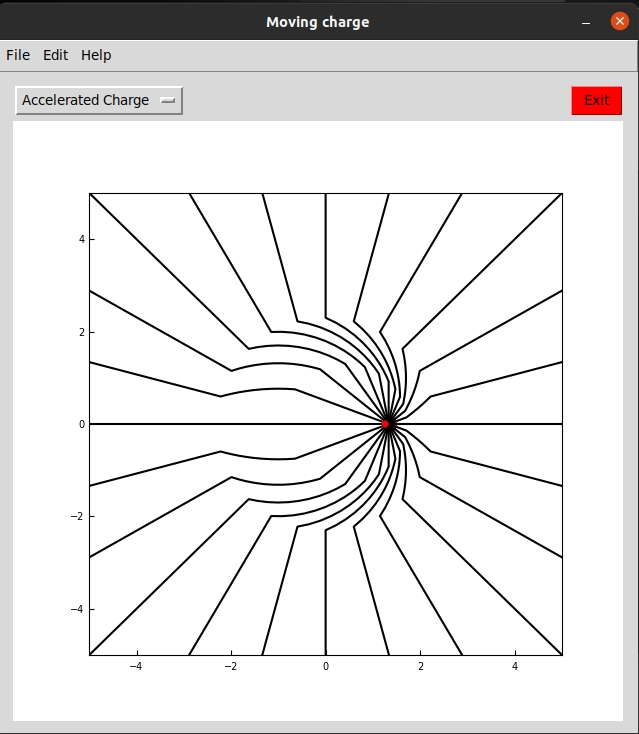

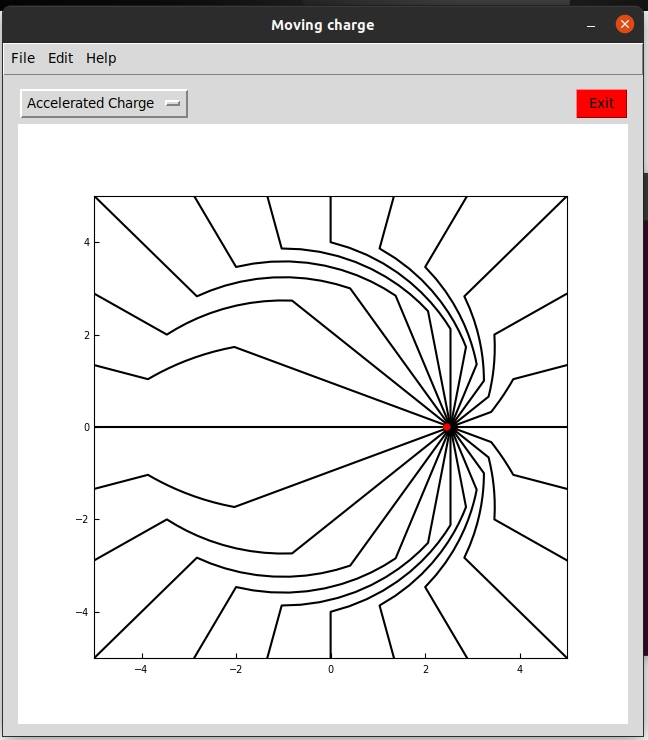

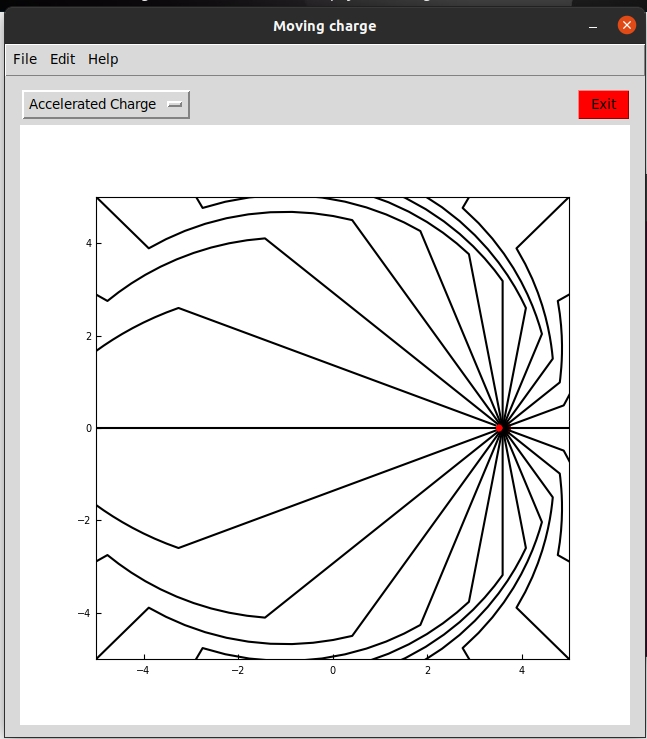

## Bremsstrahlung

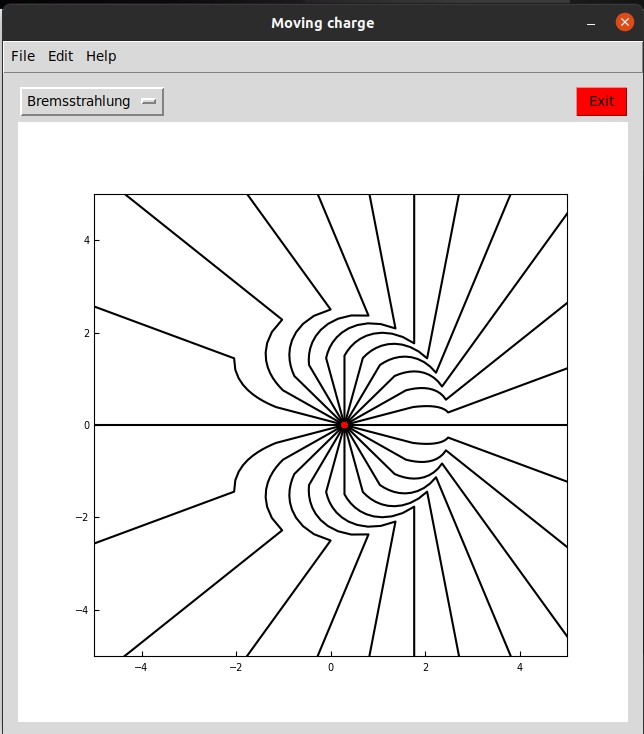

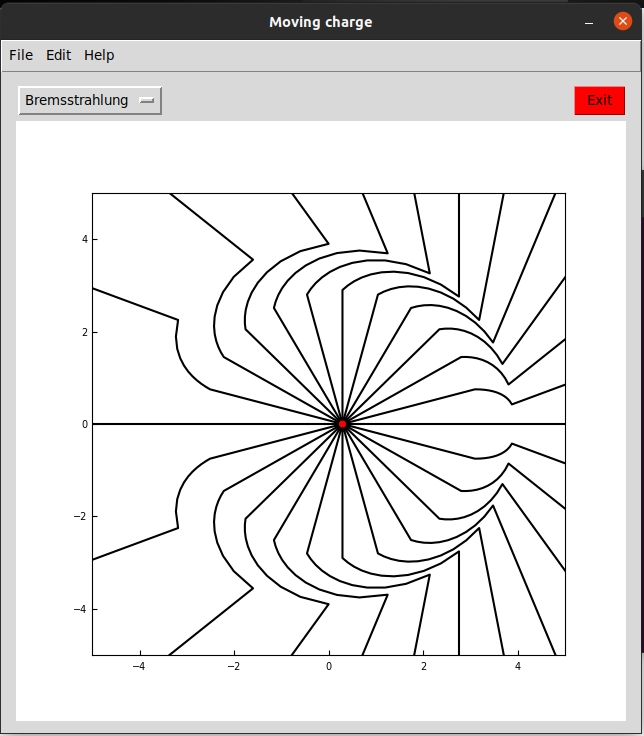

## Oscillating Charge

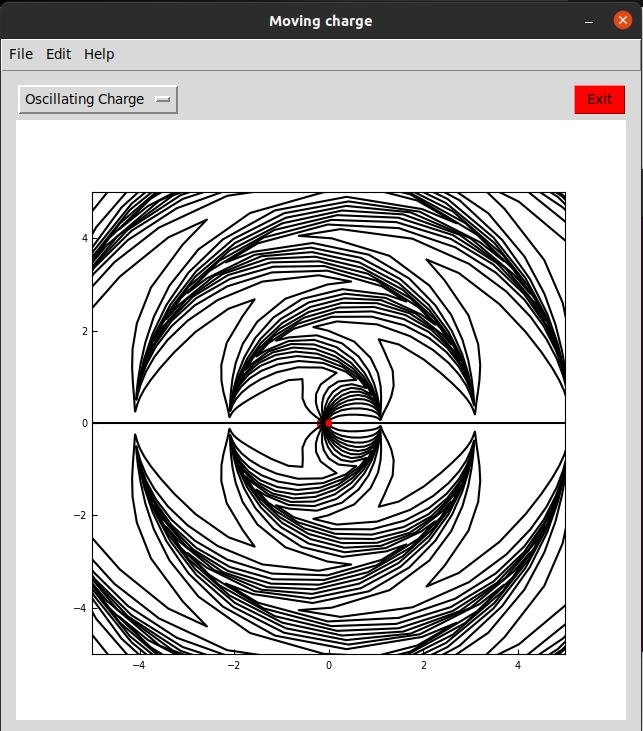

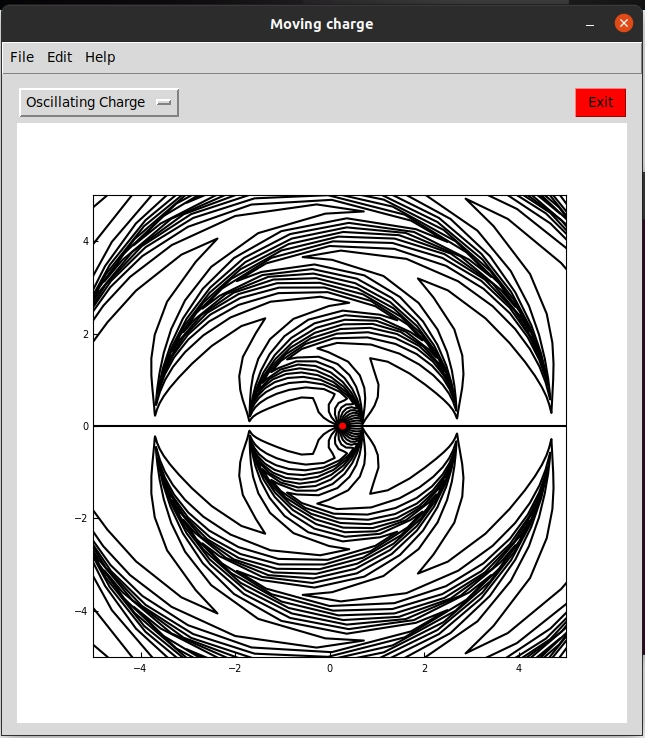